<a href="https://colab.research.google.com/github/MZen2610/DS/blob/master/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%BE_%D1%84%D0%BE%D1%82%D0%BE_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_ASPP_%D1%81%D0%B5%D1%82%D0%B8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация ASPP сети

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.

В TensorFlow инициируем режим жадного (eager) выполнения

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np

import tensorflow as tf
tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 1.15.2


###Подготовим тренировочные и тестовые данные

In [3]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

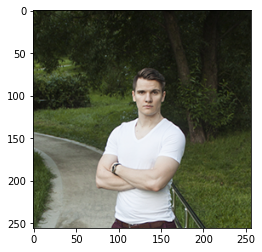

In [4]:
img = imageio.imread('/content/6.11_me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

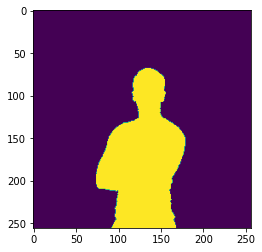

In [5]:
gt = imageio.imread('/content/6.11_me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_=plt.imshow(gt[...,0])

In [6]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

In [7]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0])
        plt.xticks([]), plt.yticks([])
    plt.show()

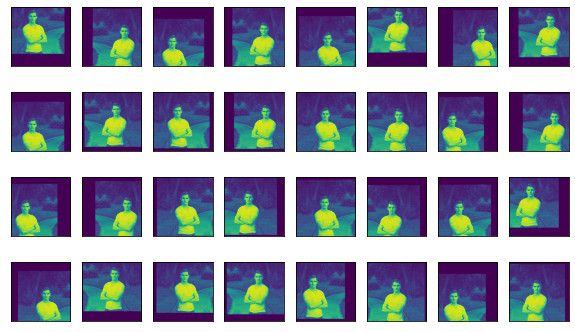

In [8]:
import random

sh_samples = 298 # Количество дополнительно сгенерированных образцов для цифр (со смещениями)

sh_train_x = np.zeros((sh_samples, 256, 256, 3), dtype=np.float32)
sh_train_y = np.zeros((sh_samples, 256, 256, 1), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), 2)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i%2], ...]

    sh_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    
    sample_y = train_y[src_idxs[i%2]]
    sh_train_y[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample_y[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(sh_train_x[:32, ...])

In [9]:
# соединим датасеты
x = np.concatenate((train_x, sh_train_x), axis=0)
y = np.concatenate((train_y, sh_train_y), axis=0)

In [10]:
# разобью на тренировочные и обучаемые

train_x = x[:250]
train_y = y[:250]

test_x = x[250:]
test_y = y[250:]

### Создание ASPP модели

In [16]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(32, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out

class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv2_2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=(2, 2))
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv4_2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', strides=(2, 2))
        self.conv5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.unpool = tf.keras.layers.UpSampling2D((2, 2))

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv2_2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out_enc_mid = out
        out = self.conv4_2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        
        out = self.aspp(out)

        out = self.conv7(out)

        out = self.unpool(out)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = self.unpool(out)
        out = tf.nn.sigmoid(out)
        return out
    
model = ASPPNet()

In [17]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss=loss,
              metrics=['accuracy'])

In [18]:
%%time

hist = model.fit(x=train_x, 
                 y=train_y, 
                 validation_data=(test_x, test_y), 
                 epochs=50, 
                 verbose=1,
                 steps_per_epoch=25, 
                 shuffle=True)

Train on 250 samples, validate on 50 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
250/250 [==============================] - 18s 72ms/sample - loss: 0.6368 - acc: 0.8374 - val_loss: 0.4201 - val_acc: 0.8707
Epoch 2/50
250/250 [==============================] - 7s 30ms/sample - loss: 0.1716 - acc: 0.9530 - val_loss: 0.0774 - val_acc: 0.9758
Epoch 3/50
250/250 [==============================] - 7s 30ms/sample - loss: 0.0565 - acc: 0.9801 - val_loss: 0.0420 - val_acc: 0.9841
Epoch 4/50
250/250 [==============================] - 7s 30ms/sample - loss: 0.0353 - acc: 0.9863 - val_loss: 0.0299 - val_acc: 0.9885
Epoch 5/50
250/250 [==============================] - 7s 30ms/sample - loss: 0.0262 - acc: 0.9899 - val_loss: 0.0241 - val_acc: 0.9907
Epoch 6/50
250/250 [==============================] - 8s 30ms/sample - loss: 0.0206 - acc: 0.9920 - val_loss: 0.0185 - val_acc: 0.9926
Epoch 7/50
250/250 [==============================

In [23]:
def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["acc"],label='train accuracy')
    plt.plot(history["val_acc"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

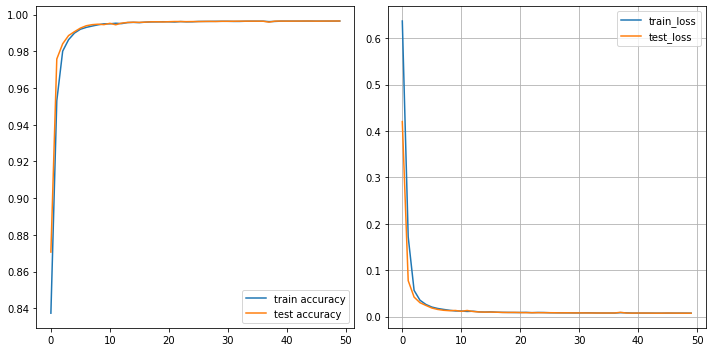

In [24]:
show_progress(hist.history)

###Проверяем на тестовых данных

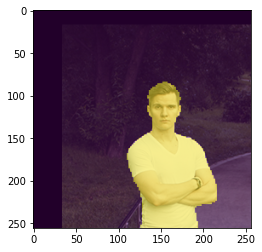

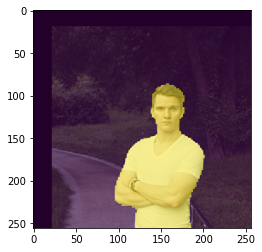

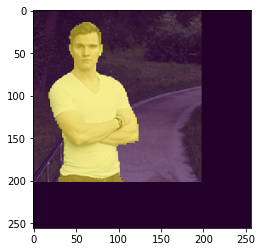

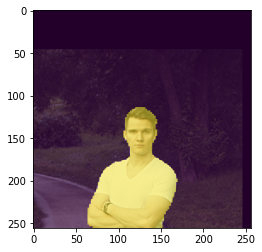

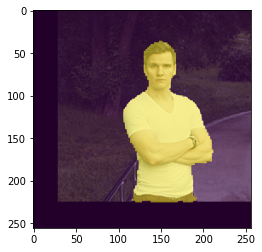

In [25]:
for sample in test_x[:5]:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()

### Загружу левую картинку и посмотрим как модель отработает на ней

In [26]:
def read_and_show(path):
    image = plt.imread(path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    return image

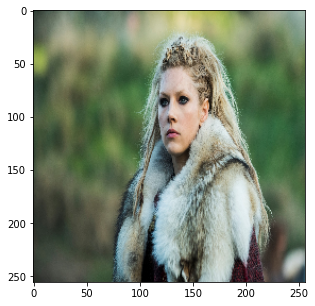

In [27]:
import numpy as np

my_foto = read_and_show("/content/598914.jpg")
gt_foto = my_foto.astype(np.float32) / 255.  # используем мое фото и меняем ему тип
gt_foto = tf.image.resize(gt_foto, (256, 256))   
_=plt.imshow(gt_foto)

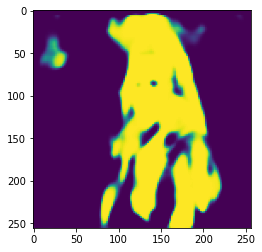

In [28]:
out = model.predict(gt_foto[None, ...])[0, ...]
_=plt.imshow(out[...,0])

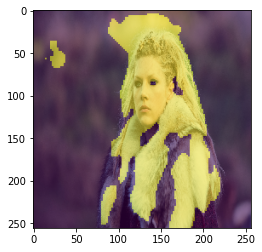

In [29]:
# наложу тепловую карту на изображение

out = model.predict(gt_foto[None, ...])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(gt_foto*0.5 + seg_map_clr*0.5)
plt.show()